## Elutionary Strategies to evolve Neural Networks - Proof of Concept

In [1]:
# Import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from random import random, randint
import tensorflow as tf
%matplotlib notebook

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Create an individual here // n_layers + space for accuracy
def individual(n_layers, minimum, maximum):
	return [ randint(minimum, maximum) for n in range(n_layers)]+[0.005, 0]

In [4]:
# Create the population here
def population(n_nets, n_layers, minimum, maximum):
	return [ individual(n_layers, minimum, maximum) for n in range(n_nets) ]

In [5]:
# Measure the fitness of an entire population. Lower is better.
def evaluate(population):
    total = np.sum(np.array([n[-1] for n in population]))
    print([n[-1] for n in population], total, float(len(population)))
    return total / float(len(population))

In [6]:
# def evaluate(population):
# 	total = np.sum(np.array(population), axis=0)
# 	return total / float(len(population))

In [7]:
# evaluate([ 0.8935, 0.9096, 0.9017, 0.8986,  0.9028, 0.5527,  0.8493, 0.8231, 0.9051, 0.8549])

In [8]:
# Evolve individuals and create the next generation. Select the 20% best. Not the best approach
def evolve(population, minimum, maximum, n_nets, n_layers, retain, random_aditional, mutation):
    ordered = [ net for net in sorted(population, key=lambda x: x[-1], reverse=True)]
    retain_length = int(retain*n_nets)
    # Print the best Net of the generation
    print("Best of that Generation: ",ordered[0])
    # Continue
    parents = ordered[:retain_length]
    # Select other individuals randomly to maintain genetic diversity. Could be avoided with a better approach.
    for net in parents:
        if random_aditional > random():
            parents.append(net)
    # Mutate some individuals to maintain genetic diversity
    for net in parents:
        for i in range(n_layers):
            if mutation > random():
                net[i] = randint(minimum, maximum)
    # Crossover of parents to generate children
    parents_length = len(parents)
    children_maxlength = n_nets - parents_length
    children = []
    while len(children) < children_maxlength:
        # Select male and female
        male = randint(0, parents_length-1)
        female = randint(0, parents_length-1)
        if male != female:
            male, female = parents[male], parents[female]
            cross_point = randint(0, n_layers+2)
            # Combine male and female
            child = male[:cross_point]+female[cross_point:]
            children.append(child)
    # Extend parents list by appending children list
    parents.extend(children)
    # Return the next Generation of individuals
    return parents


In [9]:
# Get the accuracy for a given neural net
def neural(net):
    # Get the number of neurons and define parameters
    batch_size = 100
    K = net[0]
    L = net[1]
    alpha = net[2]
    # Define Layers
    W1 = tf.Variable(tf.truncated_normal([28*28, K], stddev = 0.1))
    B1 = tf.Variable(tf.zeros([K]))
    W2 = tf.Variable(tf.truncated_normal([K, L], stddev = 0.1))
    B2 = tf.Variable(tf.zeros([L]))
    W3 = tf.Variable(tf.truncated_normal([L, 10], stddev = 0.1))
    B3 = tf.Variable(tf.zeros([10]))

    X = tf.placeholder(tf.float32, [None, 28 * 28]) 	# One layer because 28*28 gray-scaled images, the None will become the batch size
    X = tf.reshape(X, [-1, 28*28])

    # Defining the model - changing relu by my_function
    Y1 = tf.nn.relu(tf.matmul(X, W1) + B1)
    Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
    Y3 = tf.nn.softmax(tf.matmul(Y2, W3) + B3)

    init = tf.global_variables_initializer()

    # Defining the placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, 10]) 		# "One-hot" encoded vector (00001000000)

    # SUCCESS metrics
    # Loss function to determine how bad is the model
    cross_entropy = -tf.reduce_sum(Y_ * tf.log(Y3)) 	# If Y is 1, log(Y) = 0, if Y is 0, log(Y) = -infinite
    # % of correct answers found in batch
    is_correct = tf.equal(tf.argmax(Y3, 1), tf.argmax(Y_, 1))	# "One-hot" decoding here
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Training step
    optimizer = tf.train.GradientDescentOptimizer(alpha)
    train_step = optimizer.minimize(cross_entropy)

    # RUN the fuckin' code here
    sess = tf.Session() 								# Code in tf is not computed until RUN
    sess.run(init)
    # Training loop
    for i in range(125):
        # Load batch of images and correct answers
        batch_X, batch_Y = mnist.train.next_batch(batch_size)	# Train on mini_batches of 100 images
        train_data = {X: batch_X, Y_: batch_Y}
        # Train
        sess.run(train_step, feed_dict = train_data)
        # {X: batch_X, Y_: batch_Y}
        
    # Succes on training data
    a_tr, c_tr = sess.run([accuracy, cross_entropy], feed_dict = train_data)
    # Success on test data?
    test_data = {X: mnist.test.images, Y_: mnist.test.labels}
    a_test, c_test = sess.run([accuracy, cross_entropy], feed_dict = test_data)
    print("Net (1st:"+str(K)+", 2nd:"+str(L)+", Alpha:"+str(alpha)+"): acc_train:", a_tr, "|| acc_test:", a_test)
    # Closing the session
    sess.close() 
    
    return [K, L, alpha, a_test*100]

In [10]:
# tiny test
for i in range(3):
    print(neural([randint(1,100), randint(1,100), randint(1,300), 0]))

Net (1st:13, 2nd:74, Alpha:236): acc_train: 0.11 || acc_test: 0.098
[13, 74, 236, 9.7999989986419678]
Net (1st:56, 2nd:33, Alpha:10): acc_train: 0.1 || acc_test: 0.098
[56, 33, 10, 9.7999989986419678]
Net (1st:73, 2nd:53, Alpha:85): acc_train: 0.12 || acc_test: 0.098
[73, 53, 85, 9.7999989986419678]


In [11]:
# Declare parameters
N_MAX_NEURONS = 100
N_MIN_NEURONS = 1
N_LAYERS = 2
N_NETS = 10
N_ITER = 5
RETAIN = 0.2
MUTATION = RANDOM_ADD = 0.1

In [12]:
# Plot the Fitness of each generation. Lower is better
def plot_graph(eval_history):
    plt.figure()
    plt.plot(np.array(eval_history), '-ro')
    plt.grid(True)
    plt.title("Graph visualization")
    plt.xlabel("Generations")
    plt.ylabel("Average Accuracy after 10o learning episodes")
    # Plot it all
    plt.show()

Net (1st:10, 2nd:4, Alpha:0.005): acc_train: 0.62 || acc_test: 0.5425
Net (1st:26, 2nd:15, Alpha:0.005): acc_train: 0.87 || acc_test: 0.8756
Net (1st:67, 2nd:35, Alpha:0.005): acc_train: 0.99 || acc_test: 0.9077
Net (1st:64, 2nd:92, Alpha:0.005): acc_train: 0.99 || acc_test: 0.9131
Net (1st:92, 2nd:42, Alpha:0.005): acc_train: 0.93 || acc_test: 0.9035
Net (1st:80, 2nd:11, Alpha:0.005): acc_train: 0.95 || acc_test: 0.8859
Net (1st:12, 2nd:27, Alpha:0.005): acc_train: 0.87 || acc_test: 0.8045
Net (1st:21, 2nd:10, Alpha:0.005): acc_train: 0.83 || acc_test: 0.8665
Net (1st:21, 2nd:12, Alpha:0.005): acc_train: 0.92 || acc_test: 0.8547
Net (1st:76, 2nd:73, Alpha:0.005): acc_train: 0.95 || acc_test: 0.8938
[54.249989986419678, 87.560009956359863, 90.77000617980957, 91.310006380081177, 90.350008010864258, 88.590002059936523, 80.449998378753662, 86.650007963180542, 85.470008850097656, 89.380007982254028] 844.780045748 10.0
Average accuracy: 84.4780045747757
Best of that Generation:  [64, 92, 0.

<IPython.core.display.Javascript object>


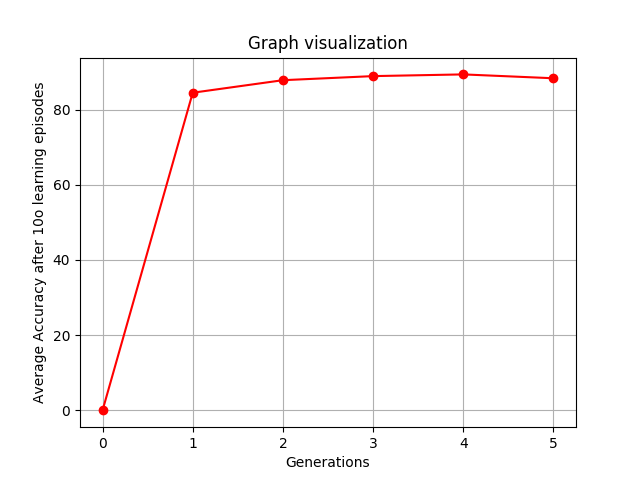

In [14]:
pop = population(N_NETS, N_LAYERS, N_MIN_NEURONS, N_MAX_NEURONS)
eval_history = [0] # Record w/ the average acc of all generations

for i in range(N_ITER):
    trained = [neural(net) for net in pop]
    score = evaluate(trained)
    print("Average accuracy: {0}".format(score))
    pop = evolve(trained, N_MIN_NEURONS, N_MAX_NEURONS, N_NETS, N_LAYERS, RETAIN, RANDOM_ADD, MUTATION)
    eval_history.append(score)
    print("------ GEN {0} ------".format(i+1))
    

print("------------------------------")
print("------------------------------")
print(eval_history)
plot_graph(eval_history)

In [ ]:
# Concept proved